<h1> Introduction to Topic Modelling</h1>

Topic Modeling is an unsupervised learning approach to clustering documents, to discover topics based on their contents. It is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. 

In this project, we’ll take a closer look at one of the popular topic models, Latent Dirichlet Allocation (LDA).

<h2>Overview of Latent Dirichlet Allocation (LDA)</h2>
LDA is a popular form of statistical topic modeling where documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. Hence, if a document uses certain words that are contained in a topic, you could say the document is about that topic.

Although a topic is composed of words, the likely distribution of those words is not equal. For example, the topic “sports” may have a probability of 50% football, 30% basketball, 20% baseball.

LDA consists of two parts, the words within a document (a known factor) and the probability of words belonging to a topic, which is what needs to be calculated. The algorithm tries to determine, for a given document, how many words belong to a specific topic. Additionally, it attempts to determine how many documents belong to a specific topic based on a certain word.

<h2>Importing libraries</h2>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns

from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# stemming - English
from nltk.stem import PorterStemmer

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import string
from pathlib import Path
from pprint import pprint

# plotting tools
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)


from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liko_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liko_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\liko_\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


<h2>Defining stopwords</h2>

In [2]:
original_stopwords = nltk.corpus.stopwords.words('english')

# update stopwords
domain_stop = ['said', 'mr']
domain_stop_update = ['would', 'also', 'could', 'make', 'two', 'made', 'like', 'say', 'one', 'people', 'new', 'year', 'use']
domain_stop_update1 = ['get', 'many', 'come', 'let', 'go', 'went', 'see', 'saw', 'still', 'take', 'know', 'want']
stopwords = set(original_stopwords+domain_stop+domain_stop_update+domain_stop_update1)

leftover = list(set(stopwords)-set(original_stopwords))

In [3]:
print(len(original_stopwords))
print(leftover)
print(len(leftover))

179
['get', 'two', 'year', 'one', 'said', 'let', 'want', 'see', 'know', 'say', 'also', 'made', 'went', 'would', 'come', 'new', 'go', 'make', 'mr', 'like', 'people', 'still', 'take', 'use', 'could', 'saw', 'many']
27


<h2>Initialising lemmatizer and stemmer</h2>

In [4]:
# initialise lemmatizer
lemma = WordNetLemmatizer()

# initialise stemmer
stemmer = PorterStemmer()

<h2>Loading data</h2>

For this project, we will use the dataset consisting of 250 news article set from BBC news.
We will explore building LDA models on various datasets using the gensim implementation of LDA.

At the same time, we will also perform lemmatisation in NLTK, it is slightly more convenient and less verbose than in spaCy. 

For visualising the topics and the word-topic distributions interactively, we'll use the 'pyLDAvis' module.

In [5]:
# r is the raw string literal so that windows path slash won't create a problem
data_folder = Path(r'news2')

# read file from the directory into array and name it corpus
corpus = []
filenames = []

for filename in data_folder.iterdir():
    fp = open(str(filename), 'r', encoding = "ISO-8859-1")
    corpus.append(fp.read())
    #keep filename for later use
    filenames.append(filename.name)
    fp.close()
    
print(str(corpus.__len__()) + " files") # print len of corpus (should be 250 files)

250 files


<h2>Cleaning:
    
<font size="4.5">Step 1: Remove punctation, stopwords, Nchar less than 3, words containing numbers \
Step 2: Lemmatize words

In [6]:
# define a new function to clean files in corpus

def clean(doc):
    punc_free = ''.join([ch for ch in doc.lower() if ch not in string.punctuation])
    digit_free = ' '.join([i for i in punc_free.split() if i.isalpha() if len(i)>=3])
    stop_free = ' '.join([i for i in digit_free.split() if i not in original_stopwords+domain_stop+domain_stop_update+domain_stop_update1])
    normalized = ' '.join(lemma.lemmatize(word) for word in stop_free.split())
    stemmed = ' '.join(stemmer.stem(word) for word in normalized.split())
    return normalized

doc_cleaned = [clean(doc).split() for doc in corpus] # loop through all documents in corpus and apply the cleaning function
doc_cleaned_cloud = [clean(doc_cleaned).strip("'") for doc_cleaned in corpus]

In [7]:
# print all terms in the first file in corpus
print(doc_cleaned[0])

['sale', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profit', 'medium', 'giant', 'timewarner', 'jumped', 'three', 'month', 'december', 'yearearlier', 'firm', 'biggest', 'investor', 'google', 'benefited', 'sale', 'highspeed', 'internet', 'connection', 'higher', 'advert', 'sale', 'timewarner', 'fourth', 'quarter', 'sale', 'rose', 'profit', 'buoyed', 'oneoff', 'gain', 'offset', 'profit', 'dip', 'warner', 'bros', 'le', 'user', 'aol', 'time', 'warner', 'friday', 'owns', 'searchengine', 'google', 'internet', 'business', 'aol', 'mixed', 'fortune', 'lost', 'subscriber', 'fourth', 'quarter', 'profit', 'lower', 'preceding', 'three', 'quarter', 'however', 'company', 'aols', 'underlying', 'profit', 'exceptional', 'item', 'rose', 'back', 'stronger', 'internet', 'advertising', 'revenue', 'hope', 'increase', 'subscriber', 'offering', 'online', 'service', 'free', 'timewarner', 'internet', 'customer', 'try', 'sign', 'aols', 'existing', 'customer', 'highspeed', 'broadband', 'timewarner', 'restate

The function cleans each of the document. Now, the content in the document is now free of stopwords, punctuations and normalised during lemmatisation.

<h2>Data transformation: Creating dictionary and corpus</h2>

In [8]:
# create word representation - term frequency or doc term matrix

dictionary = corpora.Dictionary(doc_cleaned) # this makes use of Dictionary function of gensim corpora package to create a data structure, keeping all the unique words
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_cleaned] # use dictionary to create a doc to term matrix for each document using BOW approach

<b><h1>Base model</b></h1>
We have everything required to train the base LDA model. In addition to the corpus and dictionary, we need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we’ll use the default for the base model).

In [9]:
# create lda model
# need to specify number of topics in LDA
# the output will be different for every run because this is a unsupervised learning -- set a random_state

topic_num = 8
word_num = 5
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics = topic_num, id2word = dictionary, passes=20, random_state=42)
pprint(ldamodel.print_topics(num_topics=topic_num, num_words=word_num))

# interpretation: topic 0 has 'said', 'film', 'people', 'year' and 'u' as the top 5 keywords. numbers signify their weight.

[(0,
  '0.006*"site" + 0.004*"test" + 0.004*"say" + 0.004*"iaaf" + 0.004*"thanou"'),
 (1,
  '0.004*"yukos" + 0.003*"time" + 0.003*"group" + 0.003*"court" + '
  '0.003*"yugansk"'),
 (2,
  '0.004*"game" + 0.003*"bank" + 0.003*"search" + 0.003*"back" + '
  '0.003*"software"'),
 (3,
  '0.007*"game" + 0.005*"phone" + 0.005*"call" + 0.004*"mobile" + 0.003*"say"'),
 (4,
  '0.016*"film" + 0.007*"best" + 0.005*"award" + 0.004*"director" + '
  '0.004*"actor"'),
 (5,
  '0.006*"bill" + 0.005*"lord" + 0.005*"government" + 0.004*"minister" + '
  '0.004*"plan"'),
 (6,
  '0.004*"smith" + 0.004*"robot" + 0.003*"day" + 0.003*"year" + '
  '0.003*"country"'),
 (7,
  '0.004*"airline" + 0.004*"best" + 0.004*"price" + 0.004*"job" + '
  '0.003*"government"')]


<h2>Calculate <b>baseline</b> perplexity and coherence scores</h2>

In [10]:
# Compute Perplexity # lower the better
print('Perplexity: ', ldamodel.log_perplexity(doc_term_matrix))

Perplexity:  -8.568129810930076


In [11]:
# or find highest coherence
from gensim.models import CoherenceModel

# Compute coherence score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_cleaned, 
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.33703582622581996


In [12]:
# plotting tools
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualise the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

C:\Users\liko_\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.006513  0.043297       1        1  16.243349
3     -0.006762  0.034806       2        1  14.479330
2     -0.063263  0.012830       3        1  14.440185
1      0.013730  0.040930       4        1  14.431336
5     -0.071284  0.027188       5        1  12.768501
4      0.179411 -0.016948       6        1  10.258840
0     -0.034147 -0.175219       7        1   8.789055
6     -0.024199  0.033117       8        1   8.589404, topic_info=         Term        Freq       Total Category  logprob  loglift
52       film  130.000000  130.000000  Default  30.0000  30.0000
927      best   69.000000   69.000000  Default  29.0000  29.0000
385   airline   33.000000   33.000000  Default  28.0000  28.0000
2423     bill   52.000000   52.000000  Default  27.0000  27.0000
1555    phone   54.000000   54.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2198      bbc    8.501396   73.824572   Topic8  -6.1375   0.2932
2423     bill    7.901889   52.242535   Topic8  -6.2106   0.5658
223       job    8.010639   62.261036   Topic8  -6.1969   0.4041
539      name    7.565465   35.776701   Topic8  -6.2541   0.9009
2442     dont    7.542836   41.263399   Topic8  -6.2571   0.7553

[562 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2494      1  0.087890     academy
2494      4  0.175779     academy
2494      6  0.615227     academy
2494      8  0.087890     academy
636       1  0.106148   according
...     ...       ...         ...
4362      1  0.130712         yes
4362      2  0.784269         yes
380       4  0.988260     yugansk
381       4  0.956166       yukos
6491      3  0.789013  yushchenko

[1495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 3, 2, 6, 5, 1, 7])

<h2>Finding the optimal k for the best coherence score</h2>

In [13]:
coherence = []
for k in range(15,26):
    print('Round: '+str(k))
    lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_cleaned, dictionary=dictionary, coherence='c_v')
                                                
    coherence.append((k,coherence_model_lda.get_coherence()))

Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25


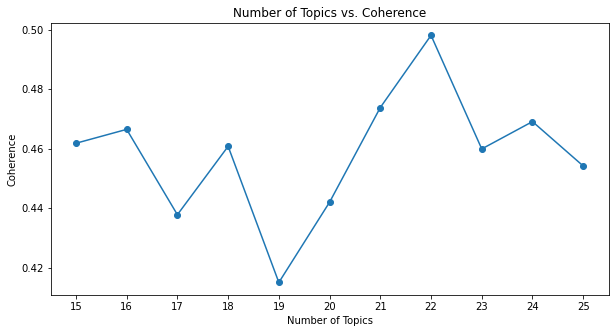

In [14]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.figure(figsize=(10,5))
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

<h2>Finding the optimal k for the best perplexity score</h2>

In [15]:
perplexity = []
for k in range(15,26):
    print('Round: '+str(k))
    lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
                                                
    perplexity.append((k,lda_model.log_perplexity(doc_term_matrix)))

Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25


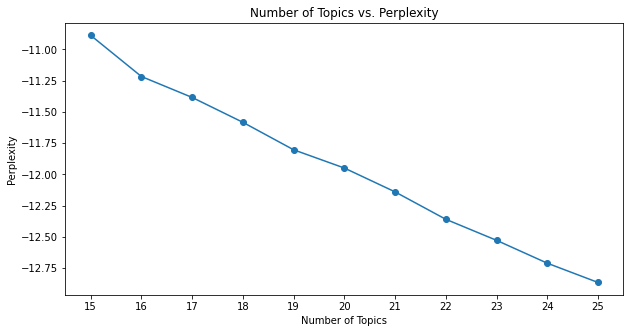

In [16]:
x_per = [x[0] for x in perplexity]
y_per = [x[1] for x in perplexity]

plt.figure(figsize=(10,5))
plt.plot(x_per,y_per)
plt.scatter(x_per,y_per)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_per)
plt.show()

<h2>Optimal k for the best coherence score</b>

In [17]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=22, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_cleaned, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.49805949396495597


In [18]:
print(lda_model.log_perplexity(doc_term_matrix))

-12.359264358182404


<h2>Visualising the topics</h2>

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\liko_\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.300775 -0.042800       1        1  22.923037
15     0.249550 -0.030631       2        1  15.937976
10     0.225128  0.128655       3        1  14.286306
1      0.248613 -0.162130       4        1  13.274193
2      0.039782  0.201862       5        1   4.933232
5      0.042994  0.193409       6        1   4.554199
14     0.033162 -0.059705       7        1   3.647363
9     -0.008907 -0.009665       8        1   3.491981
18     0.014644  0.022815       9        1   2.802872
16    -0.027854 -0.086523      10        1   2.428586
13    -0.080018 -0.045541      11        1   1.752490
12    -0.088070 -0.026614      12        1   1.676417
4     -0.104037 -0.038644      13        1   1.619476
17    -0.072775 -0.024597      14        1   1.561001
0     -0.081963  0.015812      15        1   1.404019
11    -0.084693  0.032265      16        1   1.297147
19    -0.096708 -0.015831      17        1   0.702800
21    -0.103000 -0.017861      18        1   0.601759
6     -0.105822 -0.011766      19        1   0.433510
20    -0.103089 -0.010477      20        1   0.305179
3     -0.097546 -0.002407      21        1   0.184600
8     -0.100164 -0.009626      22        1   0.181858, topic_info=             Term        Freq       Total Category  logprob  loglift
52           film  106.000000  106.000000  Default  30.0000  30.0000
2373         game  286.000000  286.000000  Default  29.0000  29.0000
927          best   62.000000   62.000000  Default  28.0000  28.0000
1555        phone   74.000000   74.000000  Default  27.0000  27.0000
250         price   71.000000   71.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3566  recognising    0.102430    1.579008  Topic22  -6.7012   3.5743
3509      tackled    0.099042    1.633236  Topic22  -6.7348   3.5069
2536    scientist    0.147268    3.812192  Topic22  -6.3381   3.0560
543       premier    0.131902    4.952588  Topic22  -6.4483   2.6841
2742        blair    0.192874   45.878474  Topic22  -6.0683   0.8380

[1110 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2850      2  0.286149     able
2850      3  0.619989     able
2850      6  0.071537     able
2850     10  0.023846     able
2850     15  0.023846     able
...     ...       ...      ...
4406     18  0.287167  yelling
635       4  0.962676      yen
380       8  0.970593  yugansk
381       8  0.945978    yukos
3920      9  0.936924   zambia

[1890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 16, 11, 2, 3, 6, 15, 10, 19, 17, 14, 13, 5, 18, 1, 12, 20, 22, 7, 21, 4, 9])

In [20]:
pprint(lda_model.print_topics(num_topics=22, num_words=10))

[(0,
  '0.024*"scottish" + 0.016*"candidate" + 0.016*"soon" + 0.016*"party" + '
  '0.015*"gift" + 0.014*"say" + 0.013*"tape" + 0.010*"blogger" + '
  '0.010*"speech" + 0.009*"building"'),
 (1,
  '0.028*"game" + 0.012*"million" + 0.011*"mobile" + 0.010*"show" + '
  '0.009*"video" + 0.009*"medium" + 0.008*"japan" + 0.008*"technology" + '
  '0.008*"website" + 0.008*"world"'),
 (2,
  '0.017*"blair" + 0.014*"law" + 0.012*"bill" + 0.012*"court" + 0.011*"ban" + '
  '0.010*"police" + 0.010*"decision" + 0.010*"change" + 0.009*"mp" + '
  '0.008*"hunt"'),
 (3,
  '0.021*"arrested" + 0.017*"bnp" + 0.009*"police" + 0.009*"criminal" + '
  '0.008*"commit" + 0.005*"griffin" + 0.004*"hatred" + 0.004*"nick" + '
  '0.003*"conspiracy" + 0.003*"tyndall"'),
 (4,
  '0.052*"film" + 0.048*"best" + 0.048*"award" + 0.019*"actor" + '
  '0.018*"nomination" + 0.014*"oscar" + 0.011*"ceremony" + 0.010*"starring" + '
  '0.010*"davis" + 0.008*"aviator"'),
 (5,
  '0.014*"government" + 0.011*"bill" + 0.011*"lord" + 0.011*"

In [21]:
topic_data = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,23): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
pd.DataFrame(all_topics).T

C:\Users\liko_\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,online,group,goal,europe,firm,european,need,company,around,time,start,playing,internet,offer,net
Topic 2,player,win,football,good,think,manager,fan,team,star,smith,match,league,project,season,scotland
Topic 3,call,system,program,child,found,issue,email,research,parent,information,message,security,body,country,campaign
Topic 4,game,mobile,million,video,show,japan,medium,website,picture,music,chelsea,gaming,record,sold,released
Topic 5,blair,law,ban,court,hunt,bill,mp,police,common,produced,food,hunting,decision,land,suspended
Topic 6,house,lord,serious,revealed,casino,suspect,bill,terror,liberal,government,democrat,plan,pas,arrest,power
Topic 7,price,growth,economy,economic,china,rate,job,tsunami,oil,germany,economist,bank,unemployment,fuel,dollar
Topic 8,camera,vehicle,design,yukos,handheld,car,yugansk,engine,madrid,nuclear,rosneft,russian,sweden,advance,banking
Topic 9,search,google,phone,cash,information,posted,definitely,questioned,individual,zambia,guantanamo,question,operating,korea,yahoo
Topic 10,minute,movie,heart,tottenham,contract,military,produce,cameroon,rooney,sign,fight,aid,considering,club,reaction
